In [1]:
"""
Imports and general setting for this notebook 
"""
import os
import numpy as np
import shdom
from tqdm import tqdm_notebook
import itertools
import sys
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import json
import pylab as py

# Change directory to pyshdom main directory
if os.getcwd().endswith('notebooks'):
    %cd '../'
    
directory = '/Users/jesserl2/Documents/Code/pyshdom_dev/gradient_test/idealized_80pts'
#cloud_path = '/Users/jesserl2/Documents/Code/pyshdom_dev/synthetic_cloud_fields/jpl_les/rico32x37x26.txt'

/Users/jesserl2/Documents/Code/pyshdom_dev


In [2]:
def process(index, stepsize,view_zenith,view_azimuth,microphysical_scatterer,variable='lwc',jacobian=False,n_jobs=40,
           solar_azimuth=0.0,solar_zenith=165.0, surface_albedo=0.0):
    index1,index2,index3 = index

    wavelengths = [0.66]
    mie_table_paths = ['/Users/jesserl2/Documents/Code/pyshdom_dev/mie_tables/polydisperse/Water_{}nm.scatpol'.format(shdom.int_round(wavelength)) \
                       for wavelength in wavelengths]
    for mie_table in mie_table_paths:
        mie = shdom.MiePolydisperse()
        mie.read_table(mie_table)
        microphysical_scatterer.add_mie(mie)
    
    if variable =='lwc':
        microphysical_scatterer._lwc.data[index1,index2,index3] +=stepsize
        lwc = shdom.GridDataEstimator(microphysical_scatterer.lwc)
        reff = microphysical_scatterer.reff
        veff = microphysical_scatterer.veff
    elif variable =='reff':
        microphysical_scatterer._reff.data[index1,index2,index3] +=stepsize
        lwc = microphysical_scatterer.lwc
        reff = shdom.GridDataEstimator(microphysical_scatterer.reff)
        veff = microphysical_scatterer.veff
    elif variable =='veff':
        microphysical_scatterer._veff.data[index1,index2,index3] +=stepsize
        lwc = microphysical_scatterer.lwc
        veff = shdom.GridDataEstimator(microphysical_scatterer.veff)
        reff = microphysical_scatterer.reff        
        
    estimator = shdom.MicrophysicalScattererEstimator(mie=microphysical_scatterer.mie,lwc=lwc,reff=reff,veff=veff)
    estimator.set_mask(estimator.get_mask(threshold=0.0))
    medium_estimator = shdom.MediumEstimator(
            loss_type='l2',
            stokes_weights=[1,1,1,0],
    )
    medium_estimator.set_grid(estimator.grid)
    medium_estimator.add_scatterer(estimator, 'cloud')
    
    # Generate a solver array for a multispectral solution
    rte_solvers = shdom.RteSolverArray()

    for wavelength in wavelengths:
        numerical_params = shdom.NumericalParameters(
            num_mu_bins=16,
            num_phi_bins=32,
            split_accuracy=0.01,
            adapt_grid_factor=100,
            solution_accuracy=1e-5,
            high_order_radiance=False
        )

        scene_params = shdom.SceneParameters(
            wavelength=wavelength,
            source=shdom.SolarSource(azimuth=solar_azimuth, zenith=solar_zenith, flux=1.0),
            surface = shdom.LambertianSurface(albedo=surface_albedo)
        ) 
        rte_solver = shdom.RteSolver(scene_params, numerical_params,num_stokes=3)
        rte_solver.set_medium(medium_estimator)
        rte_solvers.add_solver(rte_solver)
            
    rte_solvers.solve(maxiter=100, verbose=True)        
    projection = shdom.MultiViewProjection()
    sensor = shdom.StokesSensor()
    for azimuth, zenith in zip(view_azimuth, view_zenith):
        projection.add_projection(
            shdom.OrthographicProjection(
                bounding_box=microphysical_scatterer.bounding_box,
                x_resolution=0.05,
                y_resolution=0.05,
                azimuth=azimuth,
                zenith=zenith,
                altitude='TOA'))

    camera = shdom.Camera(sensor, projection)
    images = camera.render(rte_solvers, n_jobs)
    measurements = shdom.Measurements(camera, images=images, wavelength=rte_solvers.wavelength)   
    medium_estimator.compute_direct_derivative(rte_solvers)
    gradient, loss, images, jacobian = medium_estimator.compute_gradient(
        measurements=measurements,
        rte_solvers=rte_solvers,
        jacobian_flag=jacobian,
        n_jobs=n_jobs
    )
    return measurements, jacobian
            
def get_angle_set(M):
    #M is number of zenith angles.

    out = np.polynomial.legendre.leggauss(2*M)
    mus = out[0][:len(out[0])//2]
    nphis = 2*M
    nphis2 = [int(0.9+nphis*np.sqrt(1.0-mu**2)) for mu in mus]

    phis = np.concatenate([np.cumsum([360/nphi]*nphi)  for nphi in nphis2],axis=-1)
    thetas = np.concatenate([[180.0-np.rad2deg(np.arccos(mu))]*nphi for mu,nphi in zip(mus,nphis2)],axis=-1)
    return phis,thetas
            
def central_differentiation(forward_measurements,backward_measurements,h):
    pixels_forward = forward_measurements.pixels.astype(np.float64)
    pixels_backward = backward_measurements.pixels.astype(np.float64)
    partial_jacob = (pixels_forward - pixels_backward)/(2.0*np.float64(h))
    return partial_jacob

#make cloud here
def make_cloud(homogeneous_lwc=0.075,homogeneous_reff=10.0,homogeneous_veff=0.1):
    x = np.linspace(0,1.5,30)
    y = np.linspace(0,1.5,30)
    z = np.linspace(0,4.0,80)

    grid = shdom.Grid(x=x,y=y,z=z)
    lwc = np.zeros(grid.shape)
    lwc[3:-3,3:-3,3:-3] = homogeneous_lwc
    reff = np.ones(grid.shape)*homogeneous_reff
    veff= np.ones(grid.shape)*homogeneous_veff

    lwc = shdom.GridData(data=lwc,grid=grid)
    reff = shdom.GridData(data=reff,grid=grid)
    veff = shdom.GridData(data=veff,grid=grid)

    microphysical_scatterer = shdom.MicrophysicalScatterer(lwc=lwc,reff=reff,veff=veff)
    #microphysical_scatterer.load_from_csv(cloud_path, veff=0.1)
    #microphysical_scatterer.resample(grid=microphysical_scatterer.grid)
    return microphysical_scatterer

def main_process(h=2e-4,variable='lwc',input_lwc=0.01):
    view_azimuth = [0.0]
    view_zenith = [0.0]

    #h = 2e-4
    variable = 'lwc'
    #np.random.seed(1)

    microphysical_scatterer = make_cloud(homogeneous_lwc=input_lwc)
    indices = [(15,15,i) for i in range(3,77,1)]
    np.savez(os.path.join(directory,'indices.npz'),indices=indices,h=h)    
    
    
    measurements,jacobians = process(indices[0],microphysical_scatterer=microphysical_scatterer,stepsize=0.0,variable=variable,view_zenith=view_zenith,view_azimuth=view_azimuth,
            jacobian=True)

    central_diffs = []

    for i,index in enumerate(indices):
        print(i,index)
        forward_step,tmp = process(index,microphysical_scatterer=microphysical_scatterer,stepsize=h,variable=variable,view_zenith=view_zenith,view_azimuth=view_azimuth,
                                                 jacobian=True)
        backward_step,tmp= process(index,microphysical_scatterer=microphysical_scatterer,stepsize=-1*h,variable=variable,view_zenith=view_zenith,view_azimuth=view_azimuth,
                                                  jacobian=True)
        forward_step.save(os.path.join(directory,'{}_{}_forward_step_{}_{}'.format(variable,input_lwc,index,h)))
        backward_step.save(os.path.join(directory,'{}_{}_backward_step_{}_{}'.format(variable,input_lwc,index,h)))
        central_diffs.append(central_differentiation(forward_step,backward_step,h))
        print(np.sum(central_diffs[i]))
        
    sensor = shdom.StokesSensor()

    # gradient_jac=gradient_jac.reshape(jacobians.get_grid().shape)
    # mask = jacobians.get_mask()
    # gradient_jac[np.bitwise_not(mask.data)] = 0.0

    grad_approx = np.zeros((len(jacobians.projection.npix),jacobians.get_grid().shape[-1]))
    grad_central = np.zeros((len(jacobians.projection.npix),jacobians.get_grid().shape[-1]))
    grad_central_overlap = np.zeros((len(jacobians.projection.npix),jacobians.get_grid().shape[-1]))

    for i, (index, central_diff) in enumerate(zip(indices,central_diffs)):
        images_jac = jacobians.column_as_images((7,7,index[2]))
        images_central_diff = sensor.make_images(central_diffs[i],projection=jacobians.projection,num_channels=len(jacobians.wavelengths))
        for j,(image_jac,image_central) in enumerate(zip(images_jac,images_central_diff)):
            cond = np.where(np.abs(image_jac)>0.0)
            grad_central[j,index[2]] += np.sum(image_central)
            grad_approx[j,index[2]] +=np.sum(image_jac)
            grad_central_overlap[j,index[2]] +=np.sum(image_central[cond])
    return grad_approx, grad_central, grad_central_overlap

def make_fig(grad_approx,grad_central, grad_central_overlap,input_lwc,h):
    import pylab as py

    py.figure()
    py.plot(grad_approx[0,:],'x-',label='approximate')
    py.plot(grad_central[0,:],'x-', label='central differenced')
    py.plot(grad_central_overlap[0,:], label='central differenced_overlap')
    py.title('lwc {}'.format(input_lwc))
    py.legend()
    py.savefig('/Users/jesserl2/Documents/Code/pyshdom_dev/gradient_test/idealized_80pts/figures/fig_{}_h{}_dense.pdf'.format(input_lwc,h),dpi=300)


In [ ]:
for input_lwc in [0.05]:
    rad_approx, grad_central, grad_central_overlap = main_process(input_lwc=input_lwc,h=2e-4)
    make_fig(rad_approx, grad_central, grad_central_overlap,input_lwc,h=2e-4)


Reading mie table from file: /Users/jesserl2/Documents/Code/pyshdom_dev/mie_tables/polydisperse/Water_660nm.scatpol
adapt_grid_factor reduced to  3.1201534963994524
0 (15, 15, 3)
Reading mie table from file: /Users/jesserl2/Documents/Code/pyshdom_dev/mie_tables/polydisperse/Water_660nm.scatpol
adapt_grid_factor reduced to  3.1201534963994524
Reading mie table from file: /Users/jesserl2/Documents/Code/pyshdom_dev/mie_tables/polydisperse/Water_660nm.scatpol
adapt_grid_factor reduced to  3.1201534963994524
-0.00046133905973189115
1 (15, 15, 4)
Reading mie table from file: /Users/jesserl2/Documents/Code/pyshdom_dev/mie_tables/polydisperse/Water_660nm.scatpol
adapt_grid_factor reduced to  3.1201534963994524
Reading mie table from file: /Users/jesserl2/Documents/Code/pyshdom_dev/mie_tables/polydisperse/Water_660nm.scatpol
adapt_grid_factor reduced to  3.1201534963994524
-0.00015581111401097303
2 (15, 15, 5)
Reading mie table from file: /Users/jesserl2/Documents/Code/pyshdom_dev/mie_tables/po

In [6]:
view_azimuth = [0.0]
view_zenith = [0.0]
variable = 'lwc'
indices = [(7,7,i) for i in range(3,32,1)]
microphysical_scatterer = make_cloud(homogeneous_lwc=input_lwc)
measurements,jacobians = process(indices[0],microphysical_scatterer=microphysical_scatterer,stepsize=0.0,variable=variable,view_zenith=view_zenith,view_azimuth=view_azimuth,
            jacobian=True)

sensor = shdom.StokesSensor()
grad_approx = np.zeros((len(jacobians.projection.npix),jacobians.get_grid().shape[-1]))
grad_central = np.zeros((len(jacobians.projection.npix),jacobians.get_grid().shape[-1]))
grad_central_overlap = np.zeros((len(jacobians.projection.npix),jacobians.get_grid().shape[-1]))

for index in indices:
    forward = shdom.Measurements()
    forward.load(os.path.join(directory,'lwc_0.05_forward_step_(7, 7, {})_0.0002'.format(index[2])))
    backward = shdom.Measurements()
    backward.load(os.path.join(directory,'lwc_0.05_backward_step_(7, 7, {})_0.0002'.format(index[2])))
    a = central_differentiation(forward,backward,h=2e-4)
    images_jac = jacobians.column_as_images((7,7,index[2]))
    images_central_diff = sensor.make_images(a,projection=jacobians.projection,num_channels=len(jacobians.wavelengths))
    for j,(image_jac,image_central) in enumerate(zip(images_jac,images_central_diff)):
            cond = np.where(np.abs(image_jac)>0.0)
            grad_central[j,index[2]] += np.sum(image_central)
            grad_approx[j,index[2]] +=np.sum(image_jac)
            grad_central_overlap[j,index[2]] +=np.sum(image_central[cond])





Reading mie table from file: /Users/jesserl2/Documents/Code/pyshdom_dev/mie_tables/polydisperse/Water_660nm.scatpol
adapt_grid_factor reduced to  28.52711768136642


NameError: name 'py' is not defined

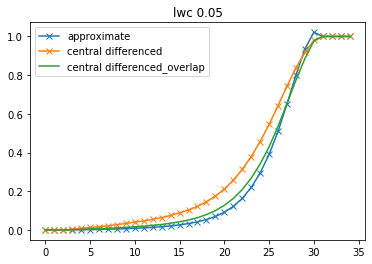

In [10]:
import pylab as py
h=2e-4
py.figure()
py.plot(np.cumsum(grad_approx[0,:]/np.sum(grad_approx[0])),'x-',label='approximate')
py.plot(np.cumsum(grad_central[0,:]/np.sum(grad_central[0])),'x-', label='central differenced')
py.plot(np.cumsum(grad_central_overlap[0,:]/np.sum(grad_central_overlap[0])), label='central differenced_overlap')
py.title('lwc {}'.format(input_lwc))
py.legend()
#py.savefig('/Users/jesserl2/Documents/Code/pyshdom_dev/gradient_test/idealized_35pts/figures/fig_{}_h{}_dense.pdf'.format(input_lwc,h),dpi=300)




In [44]:
forward = shdom.Measurements()
forward.load(os.path.join(directory,'lwc_0.4_forward_step_(7, 7, 8)_0.0002'))
backward = shdom.Measurements()
backward.load(os.path.join(directory,'lwc_0.4_backward_step_(7, 7, 8)_0.0002'))



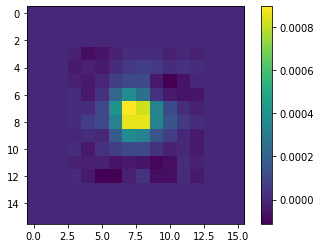

In [45]:
for image1,image2 in zip(forward.images,backward.images):
    import pylab as py
    py.figure()
    py.imshow((image1[0]-image2[0])/(2*2e-4))
    py.colorbar()
    py.show()

(array([ 39., 194.,  10.,   2.,   6.,   1.,   0.,   0.,   0.,   4.]),
 array([-1.1175871e-04, -1.1175871e-05,  8.9406967e-05,  1.8998981e-04,
         2.9057264e-04,  3.9115548e-04,  4.9173832e-04,  5.9232116e-04,
         6.9290400e-04,  7.9348683e-04,  8.9406967e-04], dtype=float32),
 <a list of 10 Patch objects>)

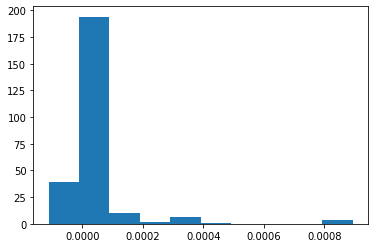

In [46]:
py.figure()
py.hist((image1[0]-image2[0]).ravel()/(2*2e-4))

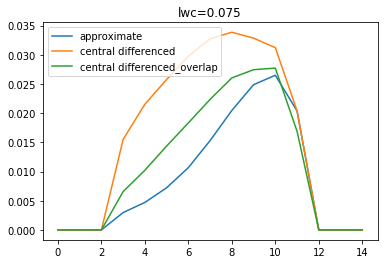

In [29]:
import pylab as py

py.figure()
py.plot(grad_approx[0,:],label='approximate')
py.plot(grad_central[0,:], label='central differenced')
py.plot(grad_central_overlap[0,:], label='central differenced_overlap')
py.title('lwc=0.075')
py.legend()

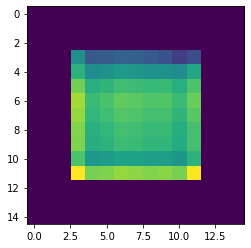

In [41]:
py.figure()
py.imshow(gradient_jac[:,:,10])

/Library/anaconda3/envs/pyshdom-dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


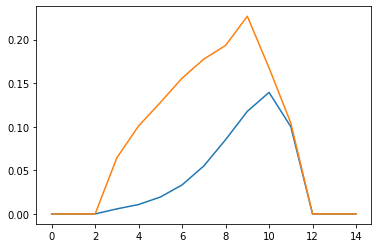

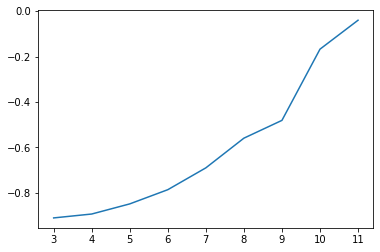

In [10]:
import pylab as py

py.figure()
py.plot(gradient_jac[7,7,:],label='approximate')
py.plot(grads[7,7,:], label='central differenced')

py.figure()
py.plot((gradient_jac[7,7,:]-grads[7,7,:])/(grads[7,7,:]))

/Library/anaconda3/envs/pyshdom-dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


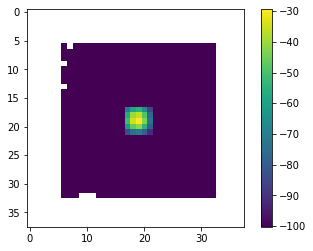

/Library/anaconda3/envs/pyshdom-dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


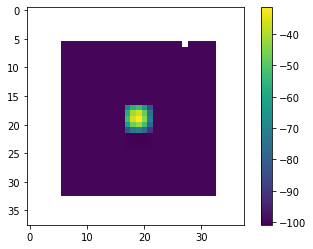

/Library/anaconda3/envs/pyshdom-dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


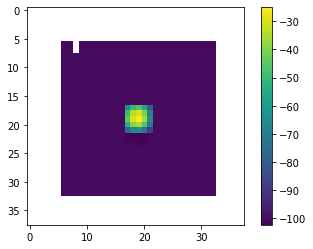

/Library/anaconda3/envs/pyshdom-dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


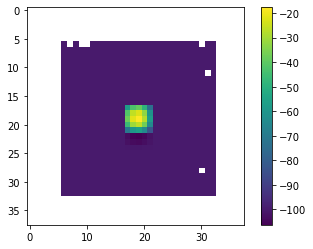

/Library/anaconda3/envs/pyshdom-dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


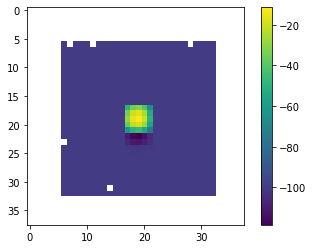

/Library/anaconda3/envs/pyshdom-dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


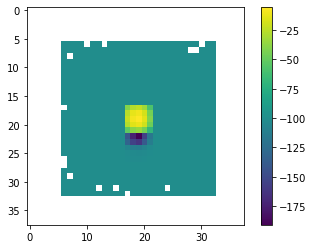

/Library/anaconda3/envs/pyshdom-dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Library/anaconda3/envs/pyshdom-dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


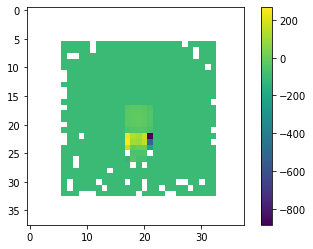

/Library/anaconda3/envs/pyshdom-dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


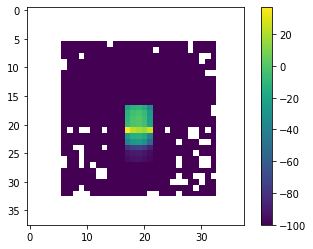

/Library/anaconda3/envs/pyshdom-dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


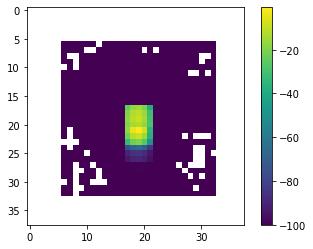

In [28]:
for i,index in enumerate(indices):
    images_jacobian = jacobians.column_as_images(index)
    sensor = shdom.StokesSensor()
    images_central_diff = sensor.make_images(central_diffs[i],projection=jacobians.projection,num_channels=len(jacobians.wavelengths))

    for image1,image2 in zip(images_central_diff,images_jacobian):
        py.figure()
        py.imshow(100*(image2[0]-image1[0])/image1[0])
        py.colorbar()
        py.show()


In [17]:
np.where(central_diffs[0]==central_diffs[0].max())

(array([0]), array([741]), array([0]))

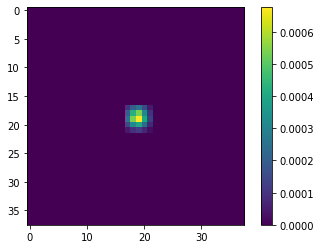

In [21]:
for image1 in images_jacobian:
    py.figure()
    py.imshow(image1[0])
    py.colorbar()
    py.show()
    



In [ ]:

    
from scripts.render_polarization_toa import RenderScript

def render(index,variable='lwc',wavelength=['0.66'],stepsize=1e-5,view_zenith=None,view_azimuth=None,n_jobs=40,
          save_all=False):
    index1,index2,index3 = index
    view_zenith = [str(i) for i in np.atleast_1d(view_zenith)] 
    view_azimuth = [str(i) for i in np.atleast_1d(view_azimuth)] 
    #print(view_azimuth)
    render_script = RenderScript()
    sys.argv = ['', ''] + wavelength + ['--generator', 'LesFile','--path', './synthetic_cloud_fields/jpl_les/rico32x37x26.txt'] + \
    ['--x_res', '0.02'] + ['--y_res', '0.02'] + ['--azimuth'] + view_azimuth + ['--zenith'] + view_zenith + \
                   ['--n_jobs', str(n_jobs), '--surface_albedo','0.0'] +\
    ['--num_mu', '4','--num_phi','8','--split_accuracy','0.01']
    
    render_script.parse_arguments()
    
    medium = render_script.get_medium()
    
    if variable == 'lwc':
        print(medium.scatterers['cloud'].lwc.data[index1,index2,index3])
        medium.scatterers['cloud'].lwc.data[index1,index2,index3] +=stepsize
        print(medium.scatterers['cloud'].lwc.data[index1,index2,index3]
    elif variable =='reff':
        medium.scatterers['cloud'].reff.data[index1,index2,index3] +=stepsize
    elif variable =='veff':
        medium.scatterers['cloud'].veff.data[index1,index2,index3] +=stepsize
    rte_solvers = shdom.RteSolverArray()
    rte_solvers.add_solver(render_script.get_solver(medium))
    rte_solvers.solve(maxiter=100, verbose=True)
    measurements = render_script.render(medium.get_scatterer('cloud').bounding_box, rte_solvers)
    if save_all:
        shdom.save_forward_model(directory,medium,rte_solvers,measurements)
    return measurements, medium,render_script.args.__dict__
    
from scripts.optimize_microphysics_lbfgs import OptimizationScript

def get_jacobian(directory=directory):

    sys.argv=  ['']+['--input_dir', directory] + \
        ['--use_forward_grid', '--use_forward_mask', '--init', 'LesFile','--path']+\
        ['./synthetic_cloud_fields/jpl_les/rico32x37x26.txt', '--use_forward_reff'] +\
        ['--use_forward_veff', '--n_jobs', '40', '--lwc_scaling', '1.0', '--reff_scaling','1.0']
    optimize_script = OptimizationScript()
    
    optimize_script.parse_arguments()
    

    medium, rte_solver, measurements = shdom.load_forward_model(optimize_script.args.input_dir)
#     ground_truth = medium.get_scatterer('cloud')
#     grid = medium.ground_truth.grid
    
#     scatterer_estimator = shdom.MicrophysicalScattererEstimator()
    
    medium_estimator = optimize_script.get_medium_estimator(measurements,medium.get_scatterer(optimize_script.scatterer_name))
    #medium_estimator._estimators['cloud'].lwc.data = medium.scatterers['cloud'].lwc.data
    options = {
            'maxiter': optimize_script.args.maxiter,
            'maxls': optimize_script.args.maxls,
            'disp': optimize_script.args.disp,
            'gtol': optimize_script.args.gtol,
            'ftol': optimize_script.args.ftol
    }
    optimizer = shdom.LocalOptimizer('L-BFGS-B', options=options, n_jobs=optimize_script.args.n_jobs)
    optimizer.set_measurements(measurements)
    optimizer.set_rte_solver(rte_solver)
    optimizer.set_medium_estimator(medium_estimator)
    optimizer.init_optimizer()
    if optimizer._init_solution is False:
            optimizer.rte_solver.make_direct()
    optimizer.rte_solver.solve(maxiter=100, init_solution=optimizer._init_solution, verbose=True)
    
    gradient, loss, images, jacobian = optimizer.medium.compute_gradient(
        rte_solvers=optimizer.rte_solver,
        measurements=optimizer.measurements,
        n_jobs=optimizer.n_jobs,
        jacobian_flag=True
        )
    
    return jacobian



[120.         240.         360.          72.         144.
 216.         288.         360.          51.42857143 102.85714286
 154.28571429 205.71428571 257.14285714 308.57142857 360.
  45.          90.         135.         180.         225.
 270.         315.         360.        ]
Reading mie table from file: mie_tables/polydisperse/Water_660nm.scatpol


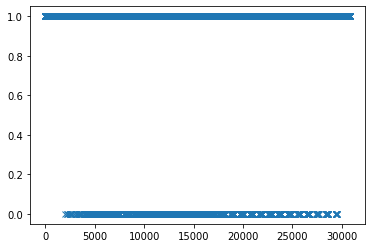

In [5]:
M=4
view_azimuth,view_zenith = get_angle_set(M)




print(view_azimuth)
reference_measurements,medium,settings = render((11,26,24),stepsize=0.0,view_zenith=view_zenith,view_azimuth=view_azimuth,
                                                save_all=True)
#jacobian = get_jacobian()
# out_dict = {}
# for key,item in settings.items():
#     out_dict[key] = str(item)
# with open(os.path.join(directory,'settings.txt'), 'w') as f:
#     json.dump(out_dict, f, indent=2)

#N=1#number of perturbations to make.
    
h = 2e-4
variable = 'lwc'
np.random.seed(1)
data = getattr(medium.scatterers['cloud'],variable).data

valid = np.where(data>3.0*h)
possibilities = len(valid[0])

#blah = np.random.randint(low=0,high=possibilities,size=N)
#indices = [(valid[0][b],valid[1][b],valid[2][b]) for b in blah]
import pylab as py
py.figure()
py.plot(np.array(data.ravel() < 2.0*h,dtype=np.int),'x')
py.show()



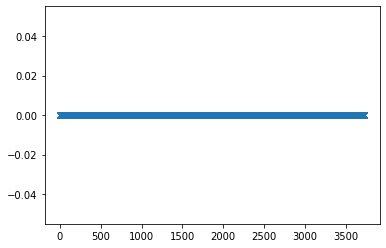

In [14]:
h = 2e-4
variable = 'lwc'
np.random.seed(1)
data = getattr(medium.scatterers['cloud'],variable).data

valid = np.where(data>2.0*h+0.01)
possibilities = len(valid[0])

#blah = np.random.randint(low=0,high=possibilities,size=N)
#indices = [(valid[0][b],valid[1][b],valid[2][b]) for b in blah]
import pylab as py
py.figure()
py.plot(np.array(data[valid] < 2.0*h,dtype=np.int),'x')
py.show()

In [15]:
len(data[valid])

3727

In [26]:

M=4
view_azimuth,view_zenith = get_angle_set(M)
print(view_azimuth)
reference_measurements,medium,settings = render((11,26,24),stepsize=0.0,view_zenith=view_zenith,view_azimuth=view_azimuth,
                                                save_all=True)
#jacobian = get_jacobian()
# out_dict = {}
# for key,item in settings.items():
#     out_dict[key] = str(item)
# with open(os.path.join(directory,'settings.txt'), 'w') as f:
#     json.dump(out_dict, f, indent=2)

#N=1#number of perturbations to make.
    
h = 2e-4
variable = 'lwc'
np.random.seed(1)
data = getattr(medium.scatterers['cloud'],variable).data

valid = np.where(data>3.0*h+0.02)
possibilities = len(valid[0])

#blah = np.random.randint(low=0,high=possibilities,size=N)
#indices = [(valid[0][b],valid[1][b],valid[2][b]) for b in blah]

indices = [(v[0],v[1],v[2]) for v in valid] #all points full jacobian.

np.savez(os.path.join(directory,'indices.npz'),indices=indices,h=h)

central_diffs = []

for i,index in enumerate(indices):
    print(i,index)
    forward_step,medium_tmp,settings = render(index,variable=variable,stepsize=h,view_zenith=view_zenith,view_azimuth=view_azimuth)
    backward_step,medium_tmp,settings = render(index,variable=variable,stepsize=-1*h,view_zenith=view_zenith,view_azimuth=view_azimuth)
    forward_step.save(os.path.join(directory,'{}_forward_step_{}_{}'.format(variable,index,h)))
    backward_step.save(os.path.join(directory,'{}_backward_step_{}_{}'.format(variable,index,h)))
    central_diffs.append(central_diff(forward_step,backward_step,h))
    print(central_diffs[i].max())
    


[120.         240.         360.          72.         144.
 216.         288.         360.          51.42857143 102.85714286
 154.28571429 205.71428571 257.14285714 308.57142857 360.
  45.          90.         135.         180.         225.
 270.         315.         360.        ]
Reading mie table from file: mie_tables/polydisperse/Water_660nm.scatpol
0.0
0.0
0 (2, 2, 2)
Reading mie table from file: mie_tables/polydisperse/Water_660nm.scatpol
0.0
0.0
Reading mie table from file: mie_tables/polydisperse/Water_660nm.scatpol
0.0
-0.0002
0.0
1 (22, 23, 23)
Reading mie table from file: mie_tables/polydisperse/Water_660nm.scatpol
0.0
0.0
Reading mie table from file: mie_tables/polydisperse/Water_660nm.scatpol
0.0
-0.0002


AssertionError: Extinction min value -0.01669126495879583 and should be larger than 0.0

array([1061])

In [33]:
valid[2][1061]

19

In [34]:
indices[0]

(9, 28, 19)

In [78]:
images_jacobian = jacobian.column_as_images(indices[0])
sensor = shdom.StokesSensor()
images_central_diff = sensor.make_images(central_diffs[0],projection=jacobian.projection,num_channels=len(jacobian.wavelengths))

pixels =  []
for image in images_jacobian:
    num_channels = image.shape[-1] if image.ndim == 4 else 1
    pixels.append(image.reshape((image.shape[0], -1, num_channels), order='F'))
pixels = np.concatenate(pixels, axis=-2)

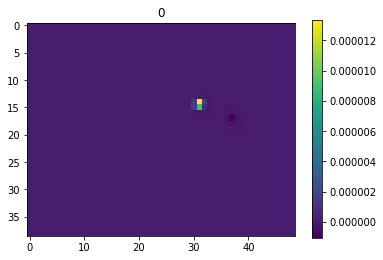

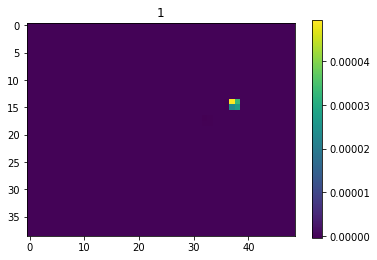

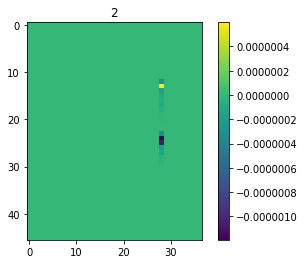

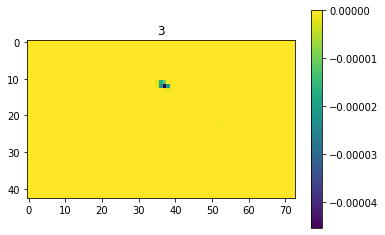

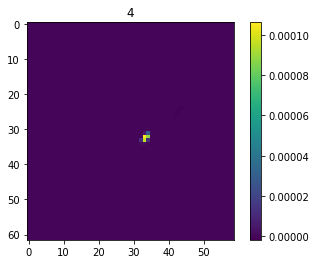

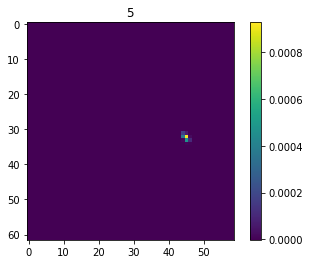

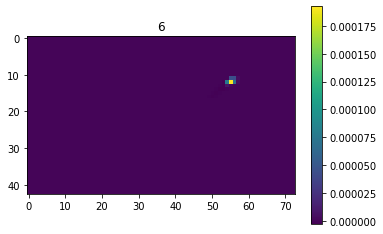

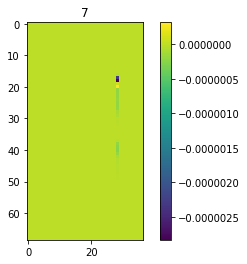

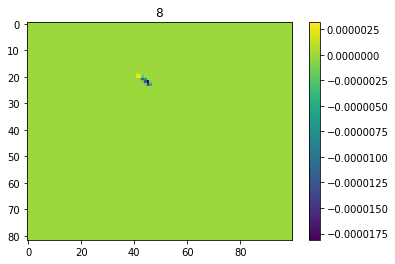

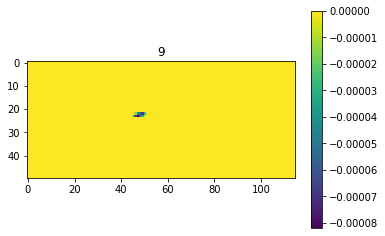

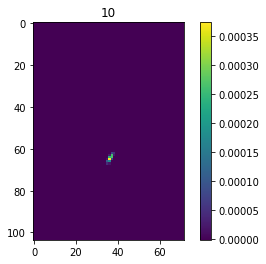

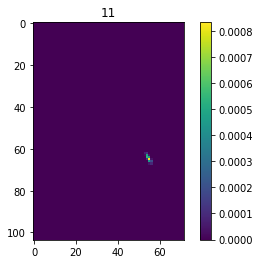

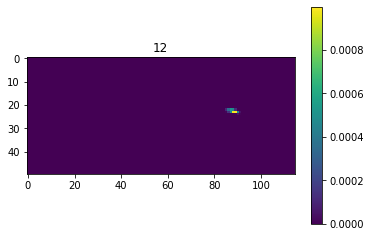

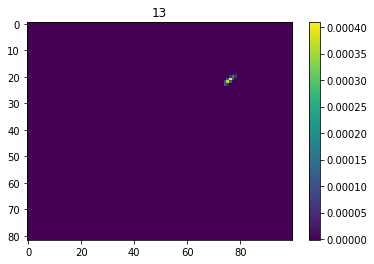

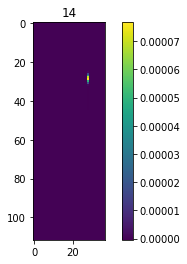

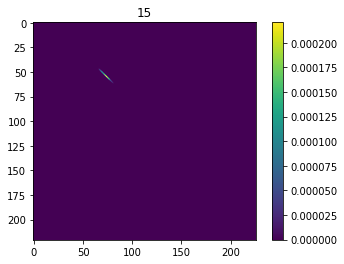

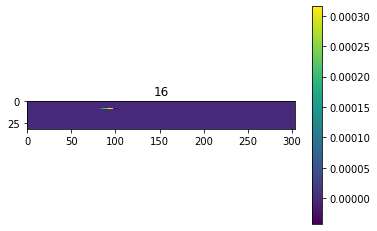

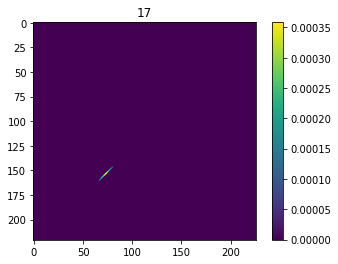

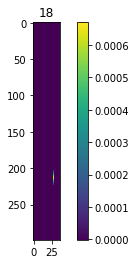

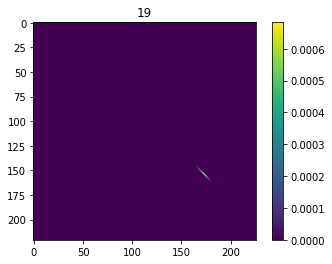

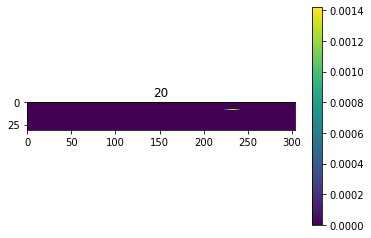

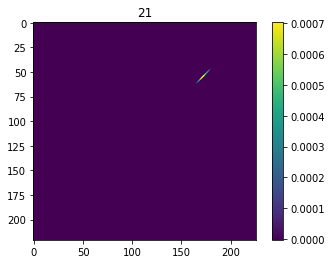

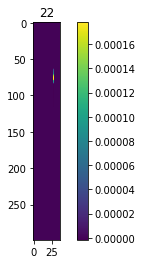

In [81]:
for i,(image1,image2) in enumerate(zip(images_jacobian,images_central_diff)):
    py.figure()
    py.imshow(image1[0])#(image1[0]-image2[0])/(image1[0]))
    py.title(str(i))
    py.colorbar()
    py.show()

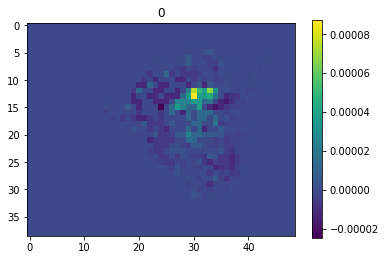

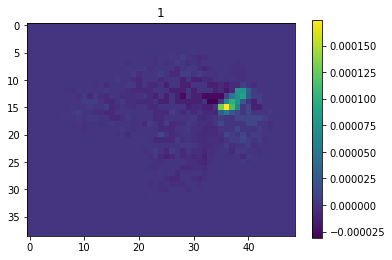

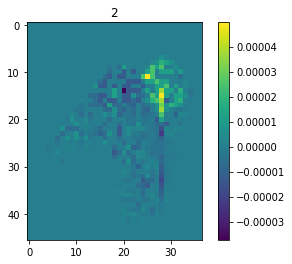

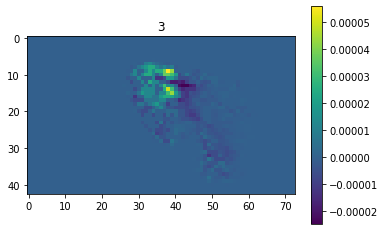

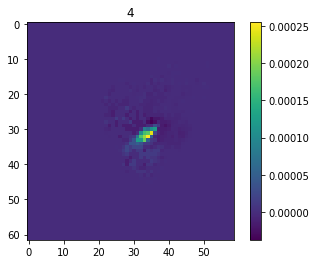

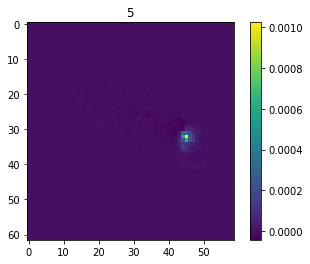

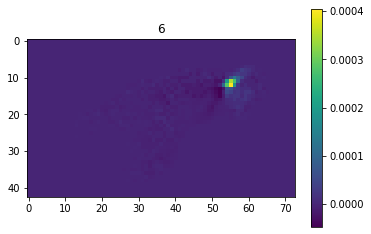

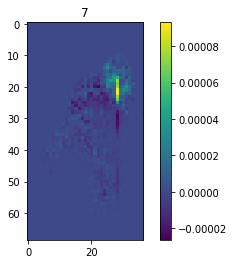

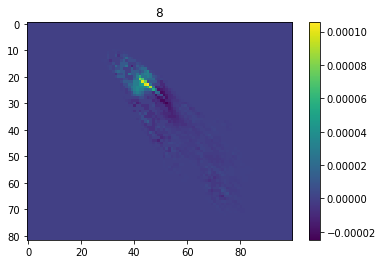

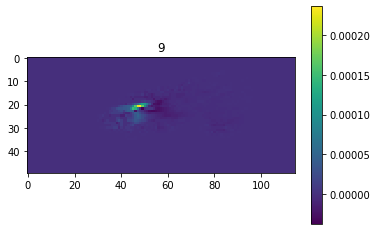

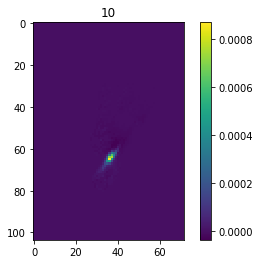

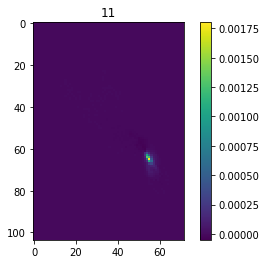

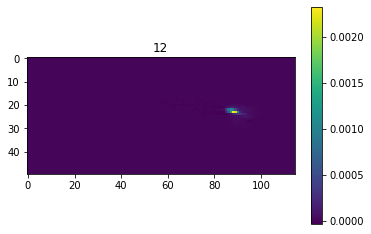

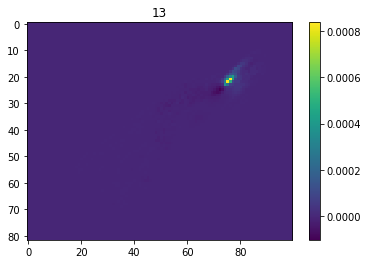

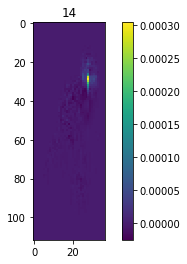

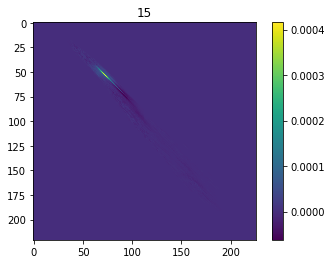

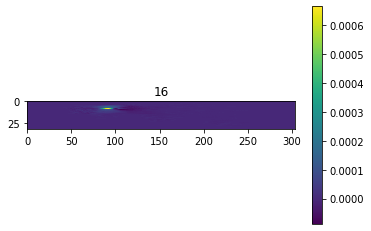

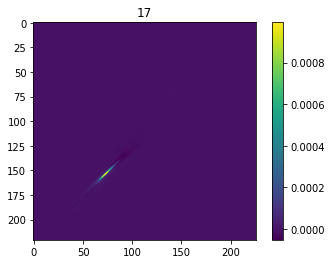

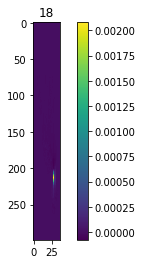

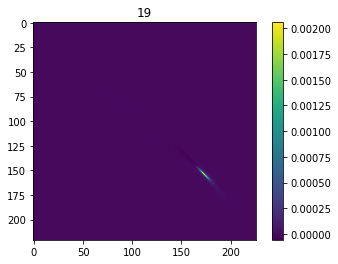

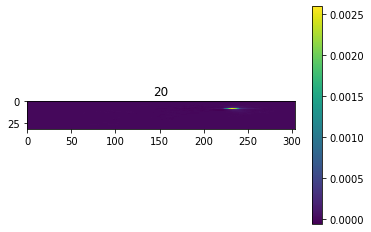

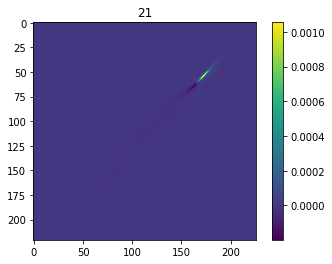

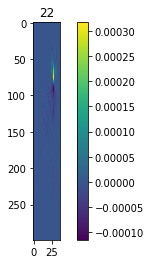

In [82]:
for i,(image1,image2) in enumerate(zip(images_jacobian,images_central_diff)):
    py.figure()
    py.imshow(image2[0])#(image1[0]-image2[0])/(image1[0]))
    py.title(str(i))
    py.colorbar()
    py.show()

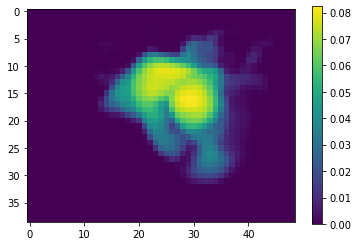

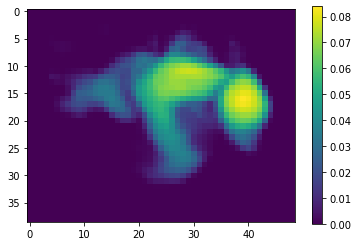

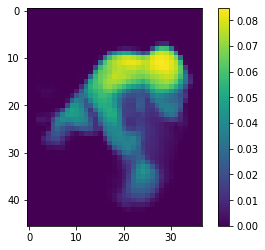

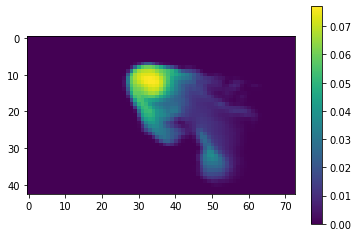

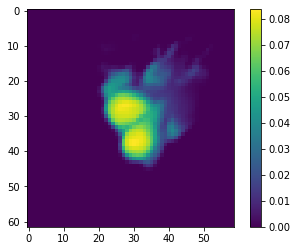

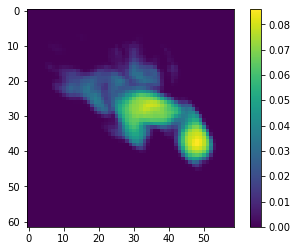

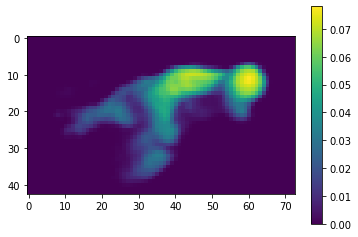

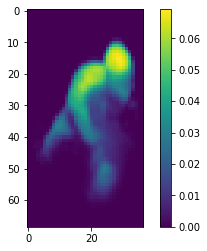

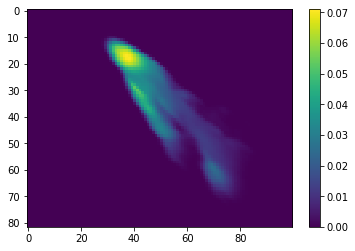

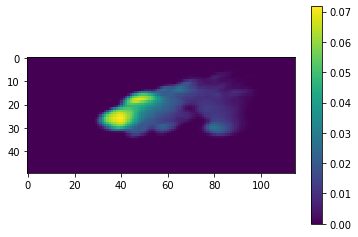

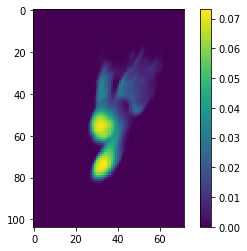

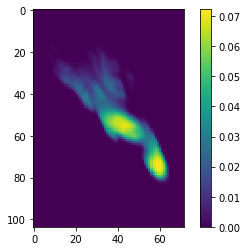

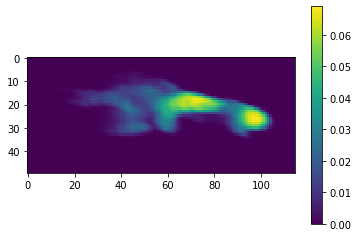

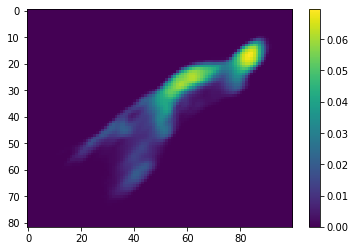

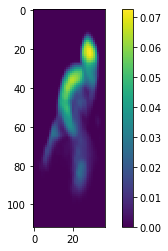

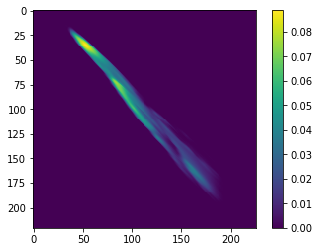

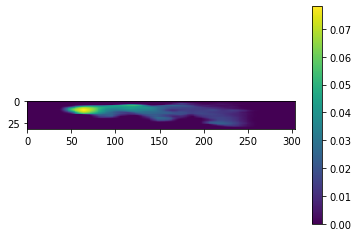

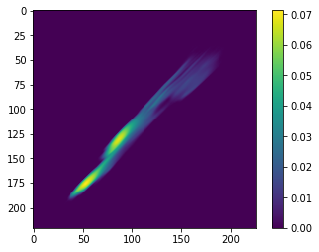

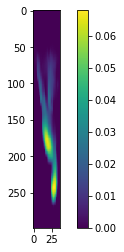

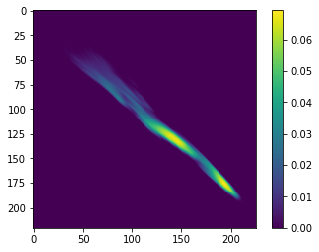

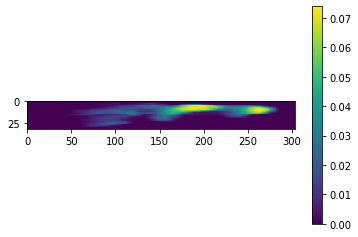

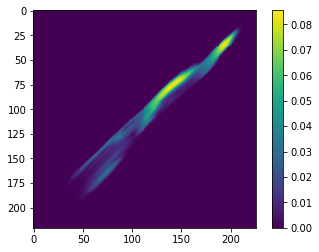

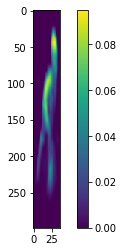

In [16]:
import pylab as py

for image1 in reference_measurements.images:#,forward_step.images):
    py.figure()
    py.imshow(image1[0])#(image1[0]-image2[0])/(image1[0]))
    py.colorbar()
    py.show()

In [71]:
pixels.shape

(3, 310057, 1)

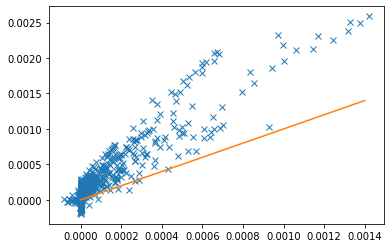

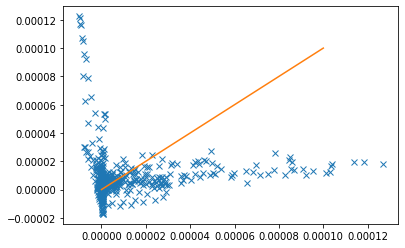

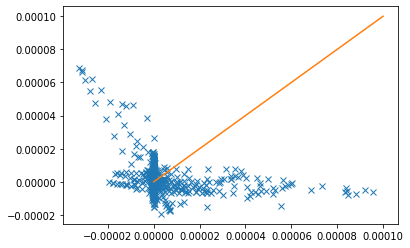

In [79]:
py.figure()
py.plot(pixels[0,:,0],central_diffs[0][0,:,0],'x')
py.plot([0,0.0014],[0,0.0014])

py.figure()
py.plot(pixels[1,:,0],central_diffs[0][1,:,0],'x')
py.plot([0,0.0001],[0,0.0001])

py.figure()
py.plot(pixels[2,:,0],central_diffs[0][2,:,0],'x')
py.plot([0,0.0001],[0,0.0001])

In [239]:
M = 12
out = np.polynomial.legendre.leggauss(2*M)
mus = out[0][:len(out[0])//2]
nphis = 2*M
nphis2 = [int(0.9+nphis*np.sqrt(1.0-mu**2)) for mu in mus]

phis = np.concatenate([np.cumsum([360/nphi]*nphi) for nphi in nphis2],axis=-1)
thetas = np.concatenate([[180.0-np.rad2deg(np.arccos(mu))]*nphi for mu,nphi in zip(mus,nphis2)],axis=-1)

        
    

In [254]:
view_azimuth

array([120.        , 240.        , 360.        ,  60.        ,
       120.        , 180.        , 240.        , 300.        ,
       360.        ,  40.        ,  80.        , 120.        ,
       160.        , 200.        , 240.        , 280.        ,
       320.        , 360.        ,  30.        ,  60.        ,
        90.        , 120.        , 150.        , 180.        ,
       210.        , 240.        , 270.        , 300.        ,
       330.        , 360.        ,  24.        ,  48.        ,
        72.        ,  96.        , 120.        , 144.        ,
       168.        , 192.        , 216.        , 240.        ,
       264.        , 288.        , 312.        , 336.        ,
       360.        ,  20.        ,  40.        ,  60.        ,
        80.        , 100.        , 120.        , 140.        ,
       160.        , 180.        , 200.        , 220.        ,
       240.        , 260.        , 280.        , 300.        ,
       320.        , 340.        , 360.        ,  18.  

In [237]:
nphis2

[3,
 6,
 9,
 12,
 15,
 18,
 21,
 24,
 26,
 29,
 31,
 34,
 36,
 38,
 40,
 41,
 43,
 44,
 45,
 46,
 47,
 48,
 48,
 48]

In [240]:
len(phis)

194

In [23]:
len(view_azimuth)

23